In [1]:
import cPickle as pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import sklearn.metrics


In [107]:
def grab(which, values=1):

#     which = 'bars'
    # values = 2

    RESULTS_DIR = '/n/regal/pfister_lab/PERCEPTION/CP_USERSTUDY/RESULTS/'
    
    results = [None]*13

    with open(RESULTS_DIR + which + '.csv', 'r') as f:
        lines = f.readlines()

    rej_cnt = 0
    for l in lines[1:]:
        if l.find('Rejected') != -1:
            rej_cnt += 1
            continue
        l_split = l.strip("\r\n").split(',')
#         print l_split
#         print l_split[-1-values]
        stimuli = int(l_split[-1 - values].split('/')[-1].split('.')[0])
        answer = [int(l_split[-1 -x].strip('\r\n').strip('"')) for x in range(values)]
        answer.reverse()

        if not results[stimuli]:
            results[stimuli] = []
        results[stimuli].append(answer)
    #         print stimuli, answer

#     print 'Rejected', rej_cnt
    
    return results

def merge(a1, a2):
    
    results = []
    for i,a in enumerate(a1):
        
         results.append(a1[i]+a2[i])
            
    assert len(results) == 13

    return results

def grabbygrab(which, values=1, GT_DIR='/n/regal/pfister_lab/PERCEPTION/CP_USERSTUDY/Figure1/', give_results=False):
    
    merged = merge(grab(which, values), grab(which+'2', values))
#     print merged
    if which == 'bars' or which == 'framed':
        gt_file = GT_DIR  + '/labels.p' 
    else:
        gt_file = GT_DIR + which + '/labels.p' 
    with open(gt_file, 'r') as f:
        labels = pickle.load(f)
        
#     print labels
    labels = np.array(labels).astype(np.float)
    
#     if values == 1:
    max_label = labels.max()
    min_label = labels.min()
#     print min_label, max_label
#     elif values == 2:
#         max_label1 = max(labels)
        
    if which=='bars' or which=='framed':
        labels == labels.ravel()
#         min_label = 0
        

    no_users = len(merged[0])
    user_results = []
    for u in range(no_users):
        
        # grab samples for this user
        samples = []
        for stimuli in merged[3:]:
            
            user_val = stimuli[u]
            
            samples.append(user_val)
            
        if values == 1:
            user_results.append(np.array(samples).astype(np.float).ravel())
        elif values == 2:
            user_results.append(np.array(samples).astype(np.float))
        
    #
    # now normalize our samples
    #
    

    if give_results:
        return user_results
    
    
    max_labels = {
        'position_common_scale': [0,60],
        'position_non_aligned_scale': [0,60],
        'length': [1, 60],
        'direction': [0,359],
        'angle': [1,90],
        'area': [3.1415, 5026.4],
        'volume': [1, 8000],
        'curvature': [0,.3],
        'shading': [0,100],
        'bars': [1,60],
        'framed': [1,60],
        'weber10': [1,10],
        'weber100': [1,10],
        'weber1000': [1,10]
    }
    
    min_label = max_labels[which][0]
    max_label = max_labels[which][1]
    
#     min_label = 0
#     max_label = 100
    for u in range(no_users):
        
        
        user_results[u] -= min_label
        user_results[u] /= (max_label - min_label)
        
    # also normalize the labels
    labels -= min_label
    labels /= (max_label - min_label)


        
    
    #
    # now calculate MLAE
    #
    MLAES = []
    AES = []
    for u in range(no_users):
        
        if which == 'curvature':
            user_results[u] /= 100
        
#         MLAE = sklearn.metrics.mean_absolute_error(user_results[u], labels)#np.log2(sklearn.metrics.mean_absolute_error(user_results[u]/100.*100, labels*100)+.125)
        MLAE = np.log2(sklearn.metrics.mean_absolute_error(user_results[u]*100, labels[3:]*100)+.125)
        MLAES.append(MLAE)
        AE = sklearn.metrics.mean_absolute_error(user_results[u]*100, labels[3:]*100)
        AES.append(AE)

#     print labels[0:5], user_results[0][0:5]
    
        
    return MLAES, AES
#     print labels, min(labels), max(labels)

In [84]:
which = ['position_common_scale', 'position_non_aligned_scale', 'length', 'direction', 'angle', 'area', 'volume', 'curvature', 'shading']

for w in which:
    MLAE, AE = grabbygrab(w)
    sorted_MLAE = sorted(MLAE)
    print w
    print ' MLAE', np.mean(sorted_MLAE[6:-6])
    print ' AE', np.mean(AE)

position_common_scale
 MLAE 3.34881979141
 AE 10.46
position_non_aligned_scale
 MLAE 3.05887139314
 AE 10.06
length
 MLAE 3.51427088742
 AE 11.9322033898
direction
 MLAE 3.75379263819
 AE 13.9788300836
angle
 MLAE 3.21845226441
 AE 10.197752809
area
 MLAE 3.64010249855
 AE 12.7397361797
volume
 MLAE 5.17759275094
 AE 38.0391548944
curvature
 MLAE 4.13489825769
 AE 17.516
shading
 MLAE 4.21987237194
 AE 18.2


In [93]:
which = ['bars', 'framed']
rect_data = []
bar_data = []
for w in which:
    MLAE, AE = grabbygrab(w,values=2, GT_DIR='/n/regal/pfister_lab/PERCEPTION/CP_USERSTUDY/Figure12/')
    sorted_MLAE = sorted(MLAE)
    print w
    
    if w =='bars':
        bar_data.append(MLAE)
    elif w == 'framed':
        rect_data.append(MLAE)
    
    print ' MLAE', np.mean(sorted_MLAE[6:-6])
    print ' AE', np.mean(AE)



bars
 MLAE 3.9609493771
 AE 15.7389830508
framed
 MLAE 3.37105247033
 AE 11.6542372881


/n/home05/haehn/.conda/envs/CP/lib/python2.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [97]:

from pyvttbl import DataFrame
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [94]:
rect_all_runs = []
for r in rect_data:
    for e in r:
        rect_all_runs.append(e)
        
print '$',np.round(np.mean(rect_all_runs),3),'$', '($SD=',np.round(np.std(rect_all_runs),3),'$)'

$ 3.336 $ ($SD= 0.828 $)


In [95]:
bar_all_runs = []
for r in bar_data:
    for e in r:
        bar_all_runs.append(e)
        
print '$',np.round(np.mean(bar_all_runs),3),'$', '($SD=',np.round(np.std(bar_all_runs),3),'$)'

$ 3.928 $ ($SD= 0.42 $)


In [99]:
# test if the difference between types was significant

df = DataFrame()
df['data'] = bar_all_runs + rect_all_runs
df['conditions'] = ['Bars']*len(bar_all_runs)+['Rect']*len(rect_all_runs)
aov_pyvttbl = df.anova1way('data', 'conditions')
print aov_pyvttbl


Anova: Single Factor on data

SUMMARY
Groups   Count    Sum     Average   Variance 
Bars        25   98.209     3.928      0.184 
Rect        25   83.405     3.336      0.714 

O'BRIEN TEST FOR HOMOGENEITY OF VARIANCE
Source of Variation     SS     df    MS       F     P-value   eta^2   Obs. power 
Treatments             3.509    1   3.509   9.422     0.004   0.164        0.801 
Error                 17.875   48   0.372                                        
Total                 21.384   49                                                

ANOVA
Source of Variation     SS     df    MS       F     P-value   eta^2   Obs. power 
Treatments             4.384    1   4.384   9.765     0.003   0.169        0.813 
Error                 21.548   48   0.449                                        
Total                 25.931   49                                                

POSTHOC MULTIPLE COMPARISONS

Tukey HSD: Table of q-statistics
       Bars     Rect   
Bars   0      4.419 ** 
Rect   

In [212]:
which = ['weber10', 'weber100', 'weber1000']
u_results = []
for w in which:
#     MLAE, AE = grabbygrab(w,values=1, GT_DIR='/n/regal/pfister_lab/PERCEPTION/CP_USERSTUDY/Weber/')
    res = grabbygrab(w,values=1, GT_DIR='/n/regal/pfister_lab/PERCEPTION/CP_USERSTUDY/Weber/', give_results=True)
    u_results.append(res)
#     sorted_MLAE = sorted(MLAE)
#     print w
#     print ' MLAE', np.mean(sorted_MLAE[6:-6])
#     print ' AE', np.mean(AE)



In [196]:
np.array(u_results[0])

array([array([ 6.,  6.,  9.,  4.,  7.,  6.,  3.,  9.,  8.,  6.]), 0,
       array([ 9.,  7.,  5.,  3.,  7.,  2.,  6.,  8.,  4.,  7.]),
       array([  8.,   8.,  10.,   1.,   3.,   7.,   5.,   7.,   8.,   8.]),
       array([ 6.,  7.,  9.,  2.,  7.,  3.,  2.,  7.,  9.,  5.]),
       array([  9.,   7.,   8.,   7.,   7.,   3.,   4.,  10.,   6.,   5.]),
       array([  5.,   8.,  10.,   3.,   8.,   3.,   4.,   9.,   6.,   7.]),
       array([  9.,   3.,  10.,   5.,   5.,   3.,   4.,   6.,   4.,   7.]),
       array([  5.,   6.,   9.,   2.,  10.,   3.,   5.,   9.,   5.,   7.]),
       array([  8.,   8.,  10.,   4.,   7.,   4.,   4.,   6.,   6.,   6.]),
       array([  8.,   6.,   6.,   2.,   6.,   2.,   4.,  10.,   6.,   8.]),
       array([  7.,  10.,   9.,   1.,   7.,   2.,   4.,  10.,   7.,   7.]),
       array([ 4.,  3.,  9.,  5.,  5.,  5.,  4.,  8.,  3.,  6.]),
       array([  6.,   7.,  10.,   5.,   6.,   5.,   4.,   3.,   6.,   5.]),
       array([  1.,   6.,   7.,   3.,  10.,   3.,

In [202]:
a = np.array(u_results[0])



In [209]:
a

array([array([ 6.,  6.,  9.,  4.,  7.,  6.,  3.,  9.,  8.,  6.]), 0,
       array([ 9.,  7.,  5.,  3.,  7.,  2.,  6.,  8.,  4.,  7.]),
       array([  8.,   8.,  10.,   1.,   3.,   7.,   5.,   7.,   8.,   8.]),
       array([ 6.,  7.,  9.,  2.,  7.,  3.,  2.,  7.,  9.,  5.]),
       array([  9.,   7.,   8.,   7.,   7.,   3.,   4.,  10.,   6.,   5.]),
       array([  5.,   8.,  10.,   3.,   8.,   3.,   4.,   9.,   6.,   7.]),
       array([  9.,   3.,  10.,   5.,   5.,   3.,   4.,   6.,   4.,   7.]),
       array([  5.,   6.,   9.,   2.,  10.,   3.,   5.,   9.,   5.,   7.]),
       array([  8.,   8.,  10.,   4.,   7.,   4.,   4.,   6.,   6.,   6.]),
       array([  8.,   6.,   6.,   2.,   6.,   2.,   4.,  10.,   6.,   8.]),
       array([  7.,  10.,   9.,   1.,   7.,   2.,   4.,  10.,   7.,   7.]),
       array([ 4.,  3.,  9.,  5.,  5.,  5.,  4.,  8.,  3.,  6.]),
       array([  6.,   7.,  10.,   5.,   6.,   5.,   4.,   3.,   6.,   5.]),
       array([  1.,   6.,   7.,   3.,  10.,   3.,

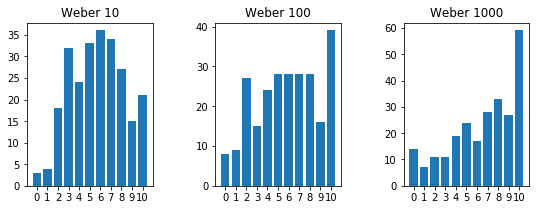

In [239]:
import matplotlib.gridspec as gridspec
plt.figure(figsize(9,3))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.5)


for i,w in enumerate(['Weber 10', 'Weber 100', 'Weber 1000']):
    ax1 = plt.subplot(gs[0, i], )

    unique, counts = numpy.unique(u_results[i], return_counts=True)
    plt.bar(unique[0:11], counts[0:11]) # remove rejects > 10
    plt.xticks(range(11))
    plt.title(w)
    
plt.savefig('../PAPER/gfx/weber_hist.pdf')

In [217]:
counts

array([14,  7, 11, 11, 19, 24, 17, 28, 33, 27, 59])